In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# For digit recognition in the clock image

In [3]:
from tensorflow.keras.models import load_model
model=load_model('models/digitRecognition.h5')
model1=load_model('models/newDigitRecognition.h5')

In [4]:
def invert_this(image_file, with_plot=False, gray_scale=False):
    image_src = image_file
    image_i = 255 - image_src
    return image_i

In [5]:
def pred(image,ch):
    image=padding(image)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image=invert_this(image, with_plot=True, gray_scale=True) # inverting the image because of the format which is required in mode input (i.e. black canvas white brush)
    plt.imshow(image)
    image = cv2.resize(image, (28, 28))
    image = image.astype('float32') / 255.0
    image = image.reshape((1, 28, 28))
#     result=str((model.predict(image) if ch==0 else model1.predict(image)).argmax(axis=1)[0])#returning numpy array having prediction
    return (model.predict(image) if ch==0 else model1.predict(image))

In [5]:
def padding(image):
    # Set the desired padding size
    top_padding = 20
    bottom_padding = 20
    left_padding = 30
    right_padding = 30

    # Calculate the new image size
    new_height = image.shape[0] + top_padding + bottom_padding
    new_width = image.shape[1] + left_padding + right_padding

    # Create a blank padded image with a white color
    padded_image = np.ones((new_height, new_width), dtype=np.uint8) * 255

    # Copy the binary image onto the padded image
    padded_image[top_padding:top_padding + image.shape[0], left_padding:left_padding + image.shape[1]] = image
    
    return padded_image


1/1 [==============================] - 0s 47ms/step
1
1/1 [==============================] - 0s 47ms/step


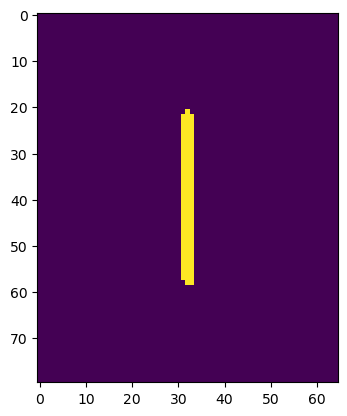

In [6]:
img=cv2.imread('images/10.jpg') #reading clock image
dimensions=img.shape
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY) 
# imgray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# binary_image = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, blockSize=11, C=2)
#finding contours
contours, hierarchy = cv2.findContours(threshold, cv2.CHAIN_APPROX_SIMPLE, cv2.CHAIN_APPROX_SIMPLE)
result=[]
dict={}

for i, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    area = cv2.contourArea(contour)
    
    asp_ratio=float(w)/h
    min_area=0.133*dimensions[0]
    max_h=0.133*dimensions[0]
    max_w=0.1066*dimensions[0]
    # Ignore irrelevent contours
    if  area<min_area or h>max_h or w>max_w: 
        continue
        
    # Crop the ROI from the original image
    roi = threshold[y:y + h, x:x + w]
    
    
    # Perform digit recognition on the ROI
#     cv2.imwrite('images/output2.jpg', roi)
#     image=cv2.imread(roi, cv2.IMREAD_GRAYSCALE)
    response=pred(roi,0)
    score=np.max(response)
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 1)
    score=f'{np.max(response):.10f}'
    result=response.argmax(axis=1)[0].__str__()#+','+str(i)

#    Display the ROI
#     cv2.imshow(f'ROI {i+1}', roi)
#     cv2.waitKey()
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5 
    if i==15:
        print(result)
    color = (255, 0, 0)
    thickness = 1
    cv2.putText(img, result, (x, y - 5), font, fontScale, color, thickness)
    dict[i]=contour

cv2.imshow('image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()


# For line detection

In [100]:
def detect_circle(image):

    circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, dp=1, minDist=100,
                               param1=50, param2=30, minRadius=0, maxRadius=0)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        largest_circle = circles[0][0]
        center_x, center_y, radius = largest_circle[0], largest_circle[1], largest_circle[2]

        # Calculating circularity
#         circularity_score = evaluate_circle_circularity(image)
#         print(circularity_score)
        return (center_x, center_y), radius

    return None

In [108]:
def detect_lines_in_circle(image, center):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresholded, cv2.CHAIN_APPROX_NONE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        contour = np.squeeze(contour)
        distances = np.linalg.norm(contour - center, axis=1)
        threshold_distance = 80
        if np.any(distances <= threshold_distance):
            epsilon = 0.05 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
    #         for i in range(1, len(approx),2):
    #             cv2.line(image, tuple(approx[i-1][0]), tuple(approx[i][0]), (0, 0, 255), 2)
            l1_a = tuple(approx[0][0])
            l1_b = tuple(approx[1][0])
            l2_a = tuple(approx[-2][0])
            l2_b = tuple(approx[-1][0])
            
    return (l1_a,l1_b,l2_a,l2_b)

Here: 
- l1_a -> staring point of line 1
- l1_b -> ending point of line 1
- l2_a -> starting point of line 2
- l2_b-> ending point of line 2

In [107]:
image=cv2.imread('images/14.jpg')
center=detect_circle(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))[0]
detect_lines_in_circle(image,center)

((458, 306), (333, 350), (426, 278), (342, 348))

# DUMP (please ignore)

In [104]:
result

['8',
 '2',
 '5',
 '0',
 '5',
 '2',
 '0',
 '2',
 '6',
 '5',
 '0',
 '8',
 '0',
 '0',
 '8',
 '0',
 '0',
 '8',
 '8',
 '8']

1/1 [==============================] - 0s 17ms/step
max= 0.9999999
The number is  3


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:737: error: (-215:Assertion failed) image.channels() == 1 || image.channels() == 3 || image.channels() == 4 in function 'cv::imwrite_'


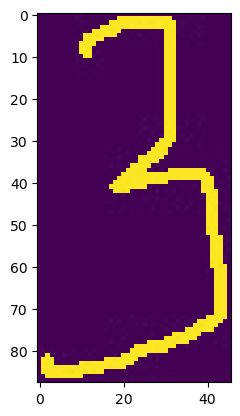

In [103]:
image=cv2.imread('images/output1.jpg', cv2.IMREAD_GRAYSCALE)
image=invert_this(image, with_plot=True, gray_scale=True) # inverting the image because of the format which is required in mode input (i.e. black canvas white brush)
plt.imshow(image)
image = cv2.resize(image, (28, 28))
image = image.astype('float32') / 255.0
image = image.reshape((1, 28, 28))
result=model.predict(image)
max=np.max(result)
print('max=',max)
print('The number is ',result.argmax(axis=1)[0])


In [172]:
from skimage.metrics import structural_similarity as ssim

def image_score():
    original_digit = cv2.imread('images/1_num.jpg')
    image1 = cv2.cvtColor(original_digit, cv2.COLOR_BGR2GRAY)# Load as grayscale

    # Load the recognized digit image
    recognized_digit = cv2.imread('images/output1.jpg')  # Load as grayscale
    image2 = cv2.cvtColor(recognized_digit, cv2.COLOR_BGR2GRAY)
    image2 = cv2.resize(image2, (28, 28))

    # Calculate the SSIM between the original and recognized digits
    score, _ = ssim(image1, image2, full=True)
    
    
    return score

In [179]:
a= image_score()
a

0.4090293584450358

In [97]:
for i in range(len(result[0])):
    print((result[0][i]))

1.9340775e-21
3.1435493e-20
2.8118363e-12
0.9999999
9.30388e-28
1.1600558e-07
4.6322716e-21
2.45416e-16
6.2071005e-17
1.3770425e-16


In [ ]:
def preprocessing(image):
    
    image=invert_this(image, with_plot=True, gray_scale=True) # inverting the image because of the format which is required in mode input (i.e. black canvas white brush)
    plt.imshow(image)
    image = cv2.resize(image, (28, 28))
    image = image.astype('float32') / 255.0
    image = image.reshape((1, 28, 28))
#     result=str((model.predict(image) if ch==0 else model1.predict(image)).argmax(axis=1)[0])#returning numpy array having prediction
    return (model.predict(image) if ch==0 else model1.predict(image))

In [90]:
a=response.argmax(axis=1)[0]
b=a.__str__()
b

'3'

In [176]:
# Function to check if the clock shape is nearly a circle
def is_circle(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, blockSize=11, C=2)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_area_contour = max(contours, key=cv2.contourArea)
    perimeter = cv2.arcLength(max_area_contour, True)
    approx_polygon = cv2.approxPolyDP(max_area_contour, 0.02 * perimeter, True)
    if len(approx_polygon) > 10:
        return True
    else:
        return False
    # Perform shape analysis on the clock_image
    # Return True if the shape is nearly a circle, otherwise False
    # You can use techniques like contour detection, circularity check, or Hough circle transform

In [442]:
circles

array([[[274, 262, 231]]], dtype=uint16)

In [277]:
photo

1

In [158]:
img=cv2.imread('images/7.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
# imgray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# binary_image = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, blockSize=11, C=2)
contours, hierarchy = cv2.findContours(threshold, cv2.CHAIN_APPROX_NONE, cv2.CHAIN_APPROX_SIMPLE)


# max_area_contour = max(contours, key=cv2.contourArea)
# perimeter = cv2.arcLength(max_area_contour, True)
# approx_polygon = cv2.approxPolyDP(max_area_contour, 0.1* perimeter, True)
for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # make a rectangle box around each curve
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 1)

        # Cropping out the digit from the image corresponding to the current contours in the for loop
        digit = threshold[y:y + h, x:x + w]

        # Resizing that digit to (18, 18)
        resized_digit = cv2.resize(digit, (18, 18))

        # Padding the digit with 5 pixels of black color (zeros) in each side to finally produce the image of (28, 28)
        padded_digit = np.pad(resized_digit, ((5, 5), (5, 5)), "constant", constant_values=0)

        digit = padded_digit.reshape(1, 28, 28, 1)
        digit = digit / 255.0

#         pred = model.predict([digit])[0]
#         final_pred = np.argmax(pred)

#         data = str(final_pred) + ' ' + str(int(max(pred) * 100)) + '%'

        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 0.5
        color = (255, 0, 0)
        thickness = 1
#         cv2.putText(img, data, (x, y - 5), font, fontScale, color, thickness)

cv2.imshow('image', img)
cv2.waitKey(0)

110

In [13]:
cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
cv2.imshow('Image',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [144]:
newImage=invert_this(image, with_plot=True, gray_scale=True)

In [143]:
def read_this(image_file, gray_scale=False):
    image_src = image_file
    if gray_scale:
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2GRAY)
    else:
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
    return image_src

def invert_this(image_file, with_plot=False, gray_scale=False):
    image_src = image_file
    image_i = 255 - image_src
    return image_i

In [228]:
circles.shape

(1, 2, 3)

In [243]:
circles

array([[[481, 337, 136]]], dtype=uint16)

In [358]:
roi

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [74]:
image = cv2.resize(image, (28, 28))
image = image.astype('float32') / 255.0
image = image.reshape((1, 28, 28))
model.predict(image).argmax(axis=1)

ValueError: cannot reshape array of size 21952 into shape (1,28,28)

In [59]:
model.predict(image).argmax(axis=1)[0]

1/1 [==============================] - 0s 25ms/step


6

In [50]:
x

array([6], dtype=int64)

In [51]:
print(x)

[6]


In [52]:
x[0]

6

array([6, 4], dtype=int64)

In [55]:
x[1]=2


IndexError: index 1 is out of bounds for axis 0 with size 1

In [68]:
pred=model.predict([image])[0]

1/1 [==============================] - 0s 30ms/step


In [66]:
data=np.argmax(pred)

In [67]:
data

8

(array([[[311, 472]],
 
        [[312, 471]],
 
        [[314, 471]],
 
        [[316, 473]],
 
        [[316, 474]],
 
        [[315, 475]],
 
        [[313, 475]],
 
        [[312, 476]],
 
        [[311, 476]],
 
        [[308, 479]],
 
        [[307, 479]],
 
        [[306, 480]],
 
        [[306, 481]],
 
        [[305, 482]],
 
        [[304, 482]],
 
        [[303, 483]],
 
        [[303, 484]],
 
        [[300, 487]],
 
        [[300, 504]],
 
        [[301, 505]],
 
        [[301, 506]],
 
        [[305, 510]],
 
        [[306, 510]],
 
        [[307, 511]],
 
        [[312, 511]],
 
        [[313, 510]],
 
        [[316, 510]],
 
        [[318, 508]],
 
        [[319, 508]],
 
        [[320, 507]],
 
        [[321, 507]],
 
        [[321, 506]],
 
        [[322, 505]],
 
        [[320, 505]],
 
        [[319, 504]],
 
        [[318, 504]],
 
        [[317, 503]],
 
        [[307, 503]],
 
        [[305, 501]],
 
        [[307, 499]],
 
        [[319, 499]],
 
        [[321, 5

In [37]:
pad=padding(cv2.imread('images/output1.jpg',cv2.IMREAD_GRAYSCALE))

In [38]:
pad.shape

(61, 95)

In [18]:
cv2.imshow('Padded Image', pad)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
padded_image = np.ones((new_height, new_width, image.shape[2]), dtype=np.uint8) 

# Copy the original image onto the padded image
padded_image[top_padding:top_padding + image.shape[0], left_padding:left_padding + image.shape[1]] = image


In [11]:
import cv2

# Load the image and convert it to grayscale
image = cv2.imread('images/9.jpg',cv2.COLOR_BGR2GRAY)
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to obtain a binary image
_, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, hierarchy = cv2.findContours(binary, cv2.CHAIN_APPROX_NONE, cv2.CHAIN_APPROX_SIMPLE)

# Iterate over each contour and its hierarchy
filtered_contours = []
for i in range(len(contours)):
    contour = contours[i]
    hierarchy_info = hierarchy[0][i]

    # Check if the contour has no child (hierarchy_info[2] == -1)
    if hierarchy_info[2] == -1:
        # Contour has no child contour, it is a parent contour
        filtered_contours.append(contour)

# Draw rectangles around the filtered contours
for contour in filtered_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the image with the rectangles
cv2.imshow('Filtered Contours with Rectangles', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [154]:
filtered_contours

[]

In [51]:
str='SWETA RAVINDRA SINGH; palak.2024bph1043@kiet.edu; devarshi.2125bph1041@kiet.edu; shivang.2125bph1023@kiet.edu; harshit.2125bph1005@kiet.edu; varnika.2125bph1027@kiet.edu; dhruv.2125cs1130@kiet.edu; gauri.2125cs1070@kiet.edu; prabhakar.2125cs1183@kiet.edu; rachitavya.2125cs@kiet.edu; vedika.2024cs1135@kiet.edu; aryan.2125cs1203@kiet.edu; shruti.2024en1052@kiet.edu; ABHINAV TRIPATHI; Aditya.2125cs1147@kiet.edu; ananya.2125cs1114@kiet.edu; kshiteesh2024cse1104@kiet.edu; kushagra.2125cs1206@kiet.edu; yash.2125cs1155@kiet.edu; piyush.2024cs1080@kiet.edu; shiva.2024cs1129@kiet.edu; pragya.2125cs1116@kiet.edu; apurwa.2125cs1139@kiet.edu; suryansh.2125cs1126@kiet.edu; 2125cs1056@kie.edu; prashant.2125csit10@kiet.edu; pranjal.2125csit1103@kiet.edu; malya.2125csit1152@kiet.edu; sampada.2125ec1073@kiet.edu; Uday.2024en1065@kiet.edu; alok.2224mca1150@kiet.edu; unnati.2224mca1156@kiet.edu; shivani.2224mca1155@kiet.edu; ankur.2224mca1055@kiet.edu; tripti.2224mca1139@kiet.edu; mansi.2224mca1027@kiet.edu; ayush.2024me1081@kiet.edu; saatvik.2024me1005@kiet.edu; mhatav.2024ce1004@kiet.edu; shreyash.2125ceme@kiet.edu; ayushmann.2024bph@kiet.edu; aman.2125cse1049@kiet.edu; Adarsh.2226en1045@kiet.edu; Anupam.2226cs1174@kiet.edu; pankaj.2226en1069@kiet.edu; chirag.2226en1044@kiet.edu; deepanshu.2024csit1168@kiet.edu; abhinav.2125csai1046@kiet.edu; nitinjay.1923en1123@kiet.edu; Atul.2125csit1059@kiet.edu; akshay.2226bph1079@kiet.edu; Mohd.2226me1044@kiet.edu; harshit.2226ec1173@kiet.edu; Kunal.2226en1081@kiet.edu; mayank.2125it1004@kiet.edu; divyanshu.2226cseai1@kiet.edu; ranjan.2125bph1026@kiet.edu; shivam.2226it1169@kiet.edu; Sanskriti.2024cse1095@kiet.edu; vanshika.2226cse1195@kiet.edu; pragya.2226it1088@kiet.edu; anushka.2226cs1017@kiet.edu; anshika.2125bph1102@kiet.edu; palak.2125ec1154@kiet.edu; tushar.2125en1044@kiet.edu; madhur.2226csit1030@kiet.edu; abha.2125csai1059@kiet.edu; kaustubh.1923ec1151@kiet.edu; ankit.1923co1041@kiet.edu; aditya.2125cseai10552@kiet.edu; vaibhav.2226bph1019@kiet.edu; ayush.1923co1040@kiet.edu; vishakha2024cs1091@kiet.edu Cc: Dr. A Garg; Joint Director; DIRECTOR OFFICE; deans@kiet.edu; KIET HoDs; ARVIND KUMAR SHARMA; BHOOPENDRA KUMAR; MANI TYAGI; PRARTHANA SRIVASTAVA; ABHISHEK KUMAR; Himanshu Saxena; pankaj.ksop@kiet.edu; Hitesh Chadha; RICHA AGARWAL; Sweta Shukla; ANUJ PATHAK; monika.kaurav@kiet.edu; PARDEEP TYAGI; Arti Sharma; Harsh Vardhan; Harsh Khatter; vikas.kamra@kiet.edu; pallavi.sharma@kiet.edu; abhishek.goyal.cs@kiet.edu; Salim; rohit.vashisht@kiet.edu; sonia.deshmukh@kiet.edu; prince.kumar@kiet.edu; Shivangi.Tyagi@kiet.edu; Shweta Singh; vidushi.mca@kiet.edu; RUPESH CHALISGAONKAR; PIYUSH PANT; Mona Agarwal; vipin.sonik@kiet.edu; SONIYA JUNEJA; Prashant Vashishtha'

In [55]:
list=str.split()

In [56]:
len(list)

140

In [12]:
result


'2,743.54088306427'

In [13]:
response

array([[1.2906178e-04, 8.1144378e-04, 7.4354088e-01, 2.5148416e-01,
        3.1104391e-05, 2.4917866e-03, 2.5752399e-04, 1.0860011e-03,
        1.1060061e-04, 5.7412890e-05]], dtype=float32)

In [16]:
f'{np.max(response):.10f}'

'0.7435408831'

In [106]:
img=cv2.imread('images/10.jpg') #reading clock image
dimensions=img.shape
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY) 
contours, hierarchy = cv2.findContours(threshold, cv2.CHAIN_APPROX_NONE, cv2.CHAIN_APPROX_SIMPLE)
for i,contour in enumerate(contours):
    _, _, _, parent_idx = hierarchy[0][i]
    # Retrieve the parent contour
    parent_contour = contours[parent_idx]

    # Calculate the area of the parent contour
    parent_contour_area = cv2.contourArea(parent_contour)

In [84]:
parent_idx

-1

In [75]:
len(contours)

25

In [77]:
list=[x for x in range(100,110)]

In [80]:
for i in enumerate(list):
    print(i)

(0, 100)
(1, 101)
(2, 102)
(3, 103)
(4, 104)
(5, 105)
(6, 106)
(7, 107)
(8, 108)
(9, 109)


In [12]:
# literally dump
flag_list=[]

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    asp_ratio=float(w)/h
    max_h=0.133*dimensions[0]
    max_w=0.1066*dimensions[0]
    # Ignore small contours
    if  h>max_h or w>max_w: 
        flag_list.append(i)

In [102]:
flag_list

[24, 24, 24, 24]

In [10]:
import cv2

# Load the clock image
clock_image = cv2.imread('images/11.jpg')

# Convert the clock image to grayscale
gray = cv2.cvtColor(clock_image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to obtain a binary image
_, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours in the thresholded image
contours, hierarchy = cv2.findContours(thresholded, cv2.CHAIN_APPROX_SIMPLE, cv2.CHAIN_APPROX_SIMPLE)

# Iterate through the contours and filter out inner contours
filtered_contours = []
for i, contour in enumerate(contours):
    # Retrieve the hierarchy information for the contour
    _, _, _, parent_idx = hierarchy[0][i]

    # Check if the contour has a parent contour
    if parent_idx == -1:
        # If the contour has no parent, it is an outer contour
        filtered_contours.append(contour)

# Draw the filtered contours on the original image
# cv2.drawContours(clock_image, filtered_contours, -1, (0, 255, 0), 2)

# Display the clock image with the filtered contours
cv2.imshow('Clock with Filtered Contours', clock_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [14]:
import pandas as pd
data=pd.read_csv('C:/Users/rachi/Downloads/dataset.csv')

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 11 columns):
 #   Column                                                     Non-Null Count  Dtype 
---  ------                                                     --------------  ----- 
 0   Demographics                                               26 non-null     object
 1   Unnamed: 1                                                 26 non-null     object
 2   Unnamed: 2                                                 26 non-null     object
 3   Interactions on Web/App (user browsed following sections)  26 non-null     object
 4   Unnamed: 4                                                 26 non-null     object
 5   Unnamed: 5                                                 26 non-null     object
 6   Doctor Visits                                              26 non-null     object
 7   Unnamed: 7                                                 26 non-null     object
 8   Lab Visit Results     

# Alternate Contour Mapping

In [47]:
image = cv2.imread('images/10.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresholded = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresholded, cv2.CHAIN_APPROX_SIMPLE, cv2.CHAIN_APPROX_NONE)

for i, contour in enumerate(contours):
        if i % 2 == 0:
            color = (0, 0, 255)  # Red color for even contours
        else:
            color = (255, 0, 0)  # Blue color for odd contours

        cv2.drawContours(image, [contour], -1, color, 2)
cv2.imshow('Image with Alternate Colored Contours', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [69]:
image = cv2.imread('images/14.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresholded = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresholded, cv2.CHAIN_APPROX_SIMPLE, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    # Apply Douglas-Peucker algorithm to simplify the contour
    epsilon = 0.0 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    for i in range(1, len(approx)):
        cv2.line(image, tuple(approx[i-1][0]), tuple(approx[i][0]), (0, 0, 255), 2)

cv2.imshow('Image with Sharp Turns', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [92]:
image = cv2.imread('images/9.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
res=detect_circle(gray)
print(res)

((328, 366), 281)


In [72]:
center = res[0]
radius = res[1]
color = (0, 0, 255)
cv2.circle(image, center, radius, color, thickness=2)

cv2.imshow('Circle', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [93]:
coordinate=res[0]

In [74]:
def point(coordinate):    # Draw a circle or marker at the coordinate
    cv2.circle(gray, coordinate, radius=5, color=(0, 0, 255), thickness=-1)
    cv2.imshow('Highlighted Coordinate', gray)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [98]:
def detect_lines_in_circle(image, center):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresholded, cv2.CHAIN_APPROX_NONE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        contour = np.squeeze(contour)
        distances = np.linalg.norm(contour - center, axis=1)
        threshold_distance = 80
        if np.any(distances <= threshold_distance):
            epsilon = 0.05 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
    #         for i in range(1, len(approx),2):
    #             cv2.line(image, tuple(approx[i-1][0]), tuple(approx[i][0]), (0, 0, 255), 2)
            l1_a = tuple(approx[0][0])
            l1_b = tuple(approx[1][0])
            l2_a = tuple(approx[-2][0])
            l2_b = tuple(approx[-1][0])
            
    return (l1_a,l1_b,l2_a,l2_b)

In [65]:
image = cv2.imread('images/9.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [64]:
for i in approx:
    coordinate=(i[0][0],i[0][1])
    point(coordinate)

In [78]:
cv2.line(image, line1_start, line1_end, (0, 0, 255), 2)
cv2.line(image, line2_start, line2_end, (0, 0, 255), 2)

# Show the image
cv2.imshow('Image with Contours', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [80]:
approx

array([[[458, 306]],

       [[333, 350]],

       [[426, 278]],

       [[342, 348]]], dtype=int32)